In [ ]:
'''put SD-1042 and buoy 42022 on the same temporal grid & compare the difference and correlation between buoy and SD-1042
Use data information directly from COMPS website: 
C12 - WFS Central Buoy, 50m Isobath (NDBC ID: 42022), is located 55 nautical miles due west of Anna Maria Island at the mouth of Tampa Bay Florida.  
This met-ocean buoy is moored in 50 meters (164 feet) of water. 
(1) WIND Measurements are collected twice per hour (timestamp at :05 and :35 minutes past the hour). 
Measurements consist of 10 minute averages of 1 second samples, with the averages centered on the hour and half hour.
(2) CURRENT Measurements are collected on the hour (timestamp at :57 for sample at the top of the next hour) and 
consist of 6 minute averages of 1 second samples, with the averages centered on the hour.
''' 
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
import re
from numpy.linalg import norm
from metpy.calc import wind_components, density, mixing_ratio_from_relative_humidity, wind_direction
from metpy.units import units
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc
from convert_dir import vector_dir_to_from

In [7]:
##### compare wind data first #####
### buoy met data info
year = '2023'
buoy_id = '42022'
path_data = '/Users/chi/Documents/Data/NDBC/'
fn_met = 'met_ndbc'+buoy_id+'_y'+year+'.txt'

### read met data
arrayMet = np.genfromtxt(path_data+fn_met,skip_header=2)
arrayMet[arrayMet== 999] = np.nan
### convert to datetime
dtimeMet = []
for i in range( arrayMet.shape[0] ):
    dtimeMet.append( datetime.datetime(int(arrayMet[i,0]),int(arrayMet[i,1]),int(arrayMet[i,2]),int(arrayMet[i,3]),int(arrayMet[i,4])) )
dtimeMet = np.array( dtimeMet )
print('buoy wind time:',dtimeMet[0:3])
### convert to u & v wind components
uwnd_buoy, vwnd_buoy = wind_components(arrayMet[:,6]*units('m/s'),arrayMet[:,5]*units.deg)
uwnd_buoy = np.array(uwnd_buoy)
vwnd_buoy = np.array(vwnd_buoy)

### SD-1042 merged nc file info
year = '2023'
platf_num = '1042'
path_airsea = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
# tlim_plot = [datetime.datetime(int(year),10,17), datetime.datetime(int(year),11,17)] ### 2023 SD1042
tlim_plot = [datetime.datetime(int(year),10,19,12), datetime.datetime(int(year),11,17)] ### 2023 SD1042 within a few km from 42022
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

### load airsea data
ds_airsea = nc.Dataset(path_airsea+'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_airsea.variables['time'][:]
# print(ds_airsea.variables['time'].units)
dtime_airsea = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uwnd_SD = ds_airsea.variables['UWND_MEAN'][:]
vwnd_SD = ds_airsea.variables['VWND_MEAN'][:]
bp_SD = ds_airsea.variables['BARO_PRES_MEAN'][:]
RH_SD = ds_airsea.variables['RH_MEAN'][:]
airT_SD = ds_airsea.variables['TEMP_AIR_MEAN'][:]
print('airsea data time:',dtime_airsea.shape, uwnd_SD.shape)
print('SD wind time:',dtime_airsea[0:3])

buoy wind time: [datetime.datetime(2023, 1, 1, 0, 5) datetime.datetime(2023, 1, 1, 0, 35)
 datetime.datetime(2023, 1, 1, 1, 5)]
airsea data time: (44040,) (44040,)
SD wind time: [datetime.datetime(2023, 10, 17, 10, 0)
 datetime.datetime(2023, 10, 17, 10, 1)
 datetime.datetime(2023, 10, 17, 10, 2)]


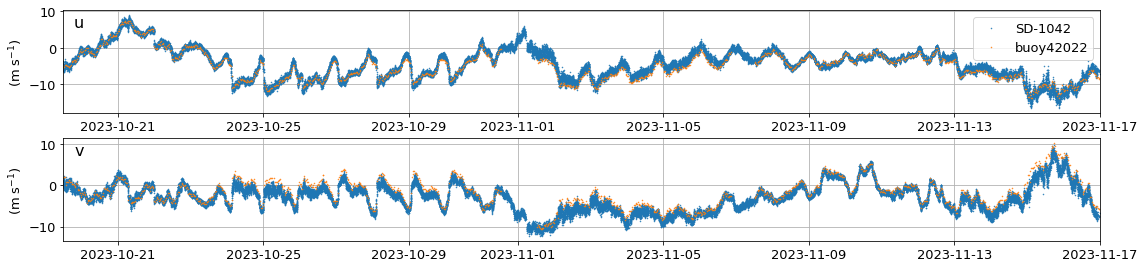

In [19]:
### test plot the original wind data from buoy C12 and SD-1042
nrow = 2
itSD = np.where( (dtime_airsea>= tlim_plot[0]) & (dtime_airsea< tlim_plot[1]) )[0]
itMet = np.where( (dtimeMet>= tlim_plot[0]) & (dtimeMet< tlim_plot[1]) )[0]
plt.clf()
plt.gcf().set_size_inches(18, 4)
plt.rcParams.update({'font.size': 13})
###
plt.subplot(nrow,1,1)
plt.plot(dtime_airsea[itSD], uwnd_SD[itSD],'.',ms=1,label='SD-'+platf_num)
plt.plot(dtimeMet[itMet], uwnd_buoy[itMet],'.',ms=1,label='buoy'+buoy_id)
plt.gca().text(0.02, 0.95, 'u', ha='right', va='top', transform=plt.gca().transAxes, fontsize=16)
plt.subplot(nrow,1,2)
plt.plot(dtime_airsea[itSD], vwnd_SD[itSD],'.',ms=1,label='SD-'+platf_num)
plt.plot(dtimeMet[itMet], vwnd_buoy[itMet],'.',ms=1,label='buoy'+buoy_id)
plt.gca().text(0.02, 0.95, 'v', ha='right', va='top', transform=plt.gca().transAxes, fontsize=16)
###
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
    if i == 0:
        plt.legend()
    plt.xlim(tlim_plot)
    plt.ylabel('(m s$^{-1}$)')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.25)
### save to figure
plt.savefig('timeseries_wind_uv_SD'+platf_num+'_vs_buoy'+buoy_id+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [8]:
### Directly compare the 10-minute moored C12 buoy site (42022) reported every 30-min to 1-min SD-1042
dtime_common = []
uwnd_SD_common = []
vwnd_SD_common = []
uwnd_buoy_common = []
vwnd_buoy_common = []
for i in range( len(dtimeMet) ):
    tlim = [dtimeMet[i]-datetime.timedelta(minutes=10), dtimeMet[i]]
    itacq_in_SD = np.where( (dtime_airsea>=tlim[0]) & (dtime_airsea<= tlim[1]) )[0]
    if len(itacq_in_SD)>= 2:
        dtime_common.append( dtimeMet[i] )
        uwnd_buoy_common.append( uwnd_buoy[i] )
        vwnd_buoy_common.append( vwnd_buoy[i] )
        uwnd_SD_common.append( np.nanmean(uwnd_SD[itacq_in_SD]) )
        vwnd_SD_common.append( np.nanmean(vwnd_SD[itacq_in_SD]) )
### put data to np.array
dtime_common = np.array( dtime_common )
uwnd_SD_common = np.array( uwnd_SD_common )
vwnd_SD_common = np.array( vwnd_SD_common )
uwnd_buoy_common = np.array( uwnd_buoy_common )
vwnd_buoy_common = np.array( vwnd_buoy_common )

### compute vector direction from
wnd_dir_from_buoy_common = np.nan*np.ones( dtime_common.shape )
wnd_dir_from_SD_common = wnd_dir_from_buoy_common.copy()
for i in range( len(dtime_common) ):
    _, wnd_dir_from_buoy_common[i] = vector_dir_to_from(uwnd_buoy_common[i],vwnd_buoy_common[i])
    _, wnd_dir_from_SD_common[i] = vector_dir_to_from(uwnd_SD_common[i],vwnd_SD_common[i])

### slice according to the tlim_plot 
it_comp = np.where( (dtime_common>= tlim_plot[0]) & (dtime_common< tlim_plot[1]) )[0]
dtime_common = dtime_common[it_comp]
uwnd_SD_common = uwnd_SD_common[it_comp]
vwnd_SD_common = vwnd_SD_common[it_comp]
uwnd_buoy_common = uwnd_buoy_common[it_comp]
vwnd_buoy_common = vwnd_buoy_common[it_comp]
wnd_dir_from_SD_common = wnd_dir_from_SD_common[it_comp]
wnd_dir_from_buoy_common = wnd_dir_from_buoy_common[it_comp]

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_97645/481488481.py:14: RuntimeWarning: Mean of empty slice
  uwnd_SD_common.append( np.nanmean(uwnd_SD[itacq_in_SD]) )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_97645/481488481.py:15: RuntimeWarning: Mean of empty slice
  vwnd_SD_common.append( np.nanmean(vwnd_SD[itacq_in_SD]) )


In [11]:
### check the wind variance
print('variance of 30-min grid buoy wind',np.nanvar(uwnd_buoy),np.nanvar(vwnd_buoy),'(m/s)^2')
print('variance of 1-min grid SD wind',np.nanvar(uwnd_SD),np.nanvar(vwnd_SD),'(m/s)^2')
print('note: the time limits of buoy wind is a year while of SD is ~1 month.')
print('variance of buoy wind resampled to buoy grid',np.nanvar(uwnd_buoy_common),np.nanvar(vwnd_buoy_common),'(m/s)^2')
print('variance of SD wind resampled to buoy grid',np.nanvar(uwnd_SD_common),np.nanvar(vwnd_SD_common),'(m/s)^2')
print( 'variance of buoy wind speed ressampled to buoy grid',np.nanvar(np.sqrt(np.square(uwnd_buoy_common)+np.square(vwnd_buoy_common))) )
print( 'variance of SD wind speed ressampled to buoy grid',np.nanvar(np.sqrt(np.square(uwnd_SD_common)+np.square(vwnd_SD_common))) )

variance of 30-min grid buoy wind 17.631445077265614 17.126847484913988 (m/s)^2
variance of 1-min grid SD wind 16.06010498816678 10.497678762808158 (m/s)^2
note: the time limits of buoy wind is a year while of SD is ~1 month.
variance of buoy wind resampled to buoy grid 15.47201070913778 11.398889377163153 (m/s)^2
variance of SD wind resampled to buoy grid 15.899476701389625 10.294334466867792 (m/s)^2
variance of buoy wind speed ressampled to buoy grid 9.017558479523283
variance of SD wind speed ressampled to buoy grid 8.982987911987633


1283


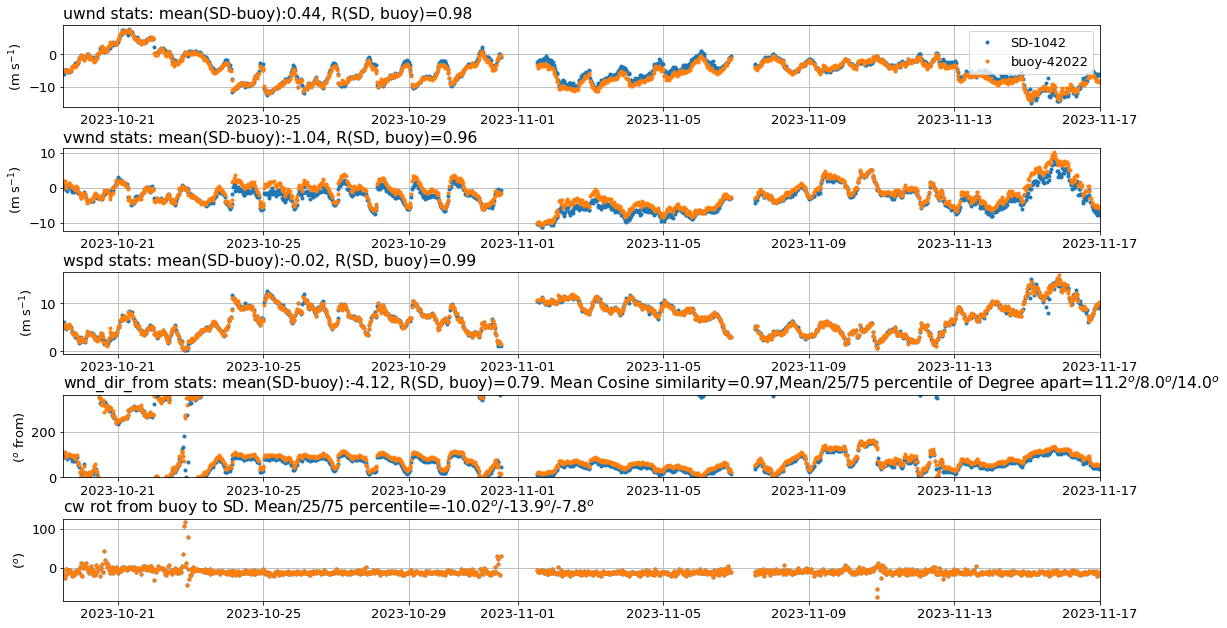

In [33]:
### compute wind speed
wspd_SD_common = np.sqrt( np.square(uwnd_SD_common) + np.square(vwnd_SD_common) )
wspd_buoy_common = np.sqrt( np.square(uwnd_buoy_common) + np.square(vwnd_buoy_common) )
isOK_common = ~np.isnan(uwnd_SD_common) & ~np.isnan(uwnd_buoy_common)
print(np.sum(isOK_common),)
### compute cosine similarity
vector_SD = np.column_stack( (uwnd_SD_common,vwnd_SD_common) )
vector_buoy = np.column_stack( (uwnd_buoy_common,vwnd_buoy_common) )
cosine_SD_buoy = np.sum(vector_SD*vector_buoy, axis=1)/(norm(vector_SD,axis=1)*norm(vector_buoy,axis=1))
deg_apart_btw_SD_buoy = np.nan*np.ones(cosine_SD_buoy.shape)
for i in range( len(cosine_SD_buoy) ):
    deg_apart_btw_SD_buoy[i] = math.degrees( math.acos(cosine_SD_buoy[i]) ) # convert radians to degree
perc = [25,75]
deg_apart_perc = np.percentile(deg_apart_btw_SD_buoy[isOK_common],perc)
### compute degree from buoy wdir to SD wdir (positive clockwise)
deg_buoy2SD_clockwise = (wnd_dir_from_SD_common-wnd_dir_from_buoy_common)
deg_buoy2SD_clockwise[deg_buoy2SD_clockwise> 180] = deg_buoy2SD_clockwise[deg_buoy2SD_clockwise> 180]-360
deg_buoy2SD_clockwise[deg_buoy2SD_clockwise< -180] = deg_buoy2SD_clockwise[deg_buoy2SD_clockwise< -180]+360
deg_buoy2SD_perc = np.percentile(deg_buoy2SD_clockwise[isOK_common],perc)
###
var_str = ['uwnd','vwnd','wspd','wnd_dir_from','cw rot from buoy to SD']
var_unit = ['(m s$^{-1}$)','(m s$^{-1}$)','(m s$^{-1}$)','($^o$ from)','($^o$)']
nrow = len(var_str)
plt.clf()
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
for i in range( len(var_str) ):
    plt.subplot(nrow,1,i+1)
    if i < len(var_str)-1:
        exec_str1 = 'var1 = '+var_str[i]+'_SD_common'
        exec_str2 = 'var2 = '+var_str[i]+'_buoy_common' 
    else:
        exec_str1 = 'var1 = deg_buoy2SD_clockwise'
        exec_str2 = 'var2 = deg_buoy2SD_clockwise'
    exec(exec_str1)
    exec(exec_str2)
    plt.plot( dtime_common, var1,'.',label='SD-'+platf_num )
    plt.plot( dtime_common, var2,'.',label='buoy-'+buoy_id )
    if i < len(var_str)-1:
        r = np.corrcoef(var1[isOK_common], var2[isOK_common])
        mn = np.mean(var1[isOK_common]-var2[isOK_common])
    ### print stats on title
    if i < 3:
        plt.title(var_str[i]+' stats: mean(SD-buoy):{:.2f}, R(SD, buoy)={:.2f}'.format(mn,r[0][1]),loc='left')
    elif i == 3:
        plt.title(var_str[i]+' stats: mean(SD-buoy):{:.2f}, R(SD, buoy)={:.2f}. Mean Cosine similarity={:.2f},Mean/{:.0f}/{:.0f} percentile of Degree apart={:.1f}$^o$/{:.1f}$^o$/{:.1f}$^o$'.\
                  format(mn,r[0][1],np.nanmean(cosine_SD_buoy),perc[0],perc[1],np.nanmean(deg_apart_btw_SD_buoy),deg_apart_perc[0],deg_apart_perc[1]),loc='left')
    else:
        plt.title(var_str[i]+'. Mean/{:.0f}/{:.0f} percentile={:.2f}$^o$/{:.1f}$^o$/{:.1f}$^o$'.\
                  format(perc[0],perc[1],np.nanmean(deg_buoy2SD_clockwise),deg_buoy2SD_perc[0],deg_buoy2SD_perc[1]),loc='left')

for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
    plt.xlim(tlim_plot)
    plt.ylabel(var_unit[i])
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylim([0,360])    

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.5)
### save to figure
plt.savefig('timeseries_wind_dir_SD'+platf_num+'_vs_buoy'+buoy_id+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [24]:
##### compare current data #####
### buoy current data info
path_data = '/Users/chi/Documents/Data/NDBC/'
fn_cur = 'current_ndbc'+buoy_id+'_y'+year+'.txt'
### Read buoy current data
nline_header = 2 ### need to check lines of headers manually
with open(path_data+fn_cur, 'r') as f:
    nrow = len(f.readlines())
    print('Total Number of lines in the current data file:', nrow)
### get the headers & number of items in the header
count = 0
print('The caveat is that the file does not have exact same number of items in the header as in the data...')
with open(path_data+fn_cur, 'r') as f:
    for line in f:
        if count == nline_header:
            line_1 = re.sub(r"\s+",',',line) ### replace space(s) with ','
            if line_1[-1] == ',':
                line_1 = line_1[:-1]
            break
        count = count + 1
### read through the file
line_1_list = line_1.split(',')
ncol = len(line_1_list) # number of items in the first line of data
arrayCur = np.nan*np.ones( (nrow-nline_header,ncol) ) ### record values only
count = 0
with open(path_data+fn_cur) as f:
    for line in f:
        count = count + 1
        line_1 = re.sub(r"\s+",',',line)
        if line_1[-1] == ',':
                line_1 = line_1[:-1]
        # print(line_1)
        if count > nline_header:
            temp = line_1.split(',')
            temp = [float(item) for item in temp]
            nitem = len(temp)
            arrayCur[count-nline_header-1,0:nitem] = np.array(temp)
        
print('Shape of arrayCur:',arrayCur.shape)
arrayCur[arrayCur == 999] = np.nan

### convert to datetime
dtime_cur_buoy = []
for i in range( arrayCur.shape[0] ):
    dtime_cur_buoy.append( datetime.datetime(int(arrayCur[i,0]),int(arrayCur[i,1]),int(arrayCur[i,2]),int(arrayCur[i,3]),int(arrayCur[i,4])) )
dtime_cur_buoy = np.array( dtime_cur_buoy )
print(dtime_cur_buoy[0:3],dtime_cur_buoy[-1])

### depths of current
depths_cur_buoy = arrayCur[0,5:-1:3]
print('Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters:', depths_cur_buoy)

### compute u & v current velocity from speed (cm/s) and direction (flowing toward) from the current data
uCur_buoy = np.nan*np.ones( (arrayCur.shape[0],len(depths_cur_buoy)) )
vCur_buoy = uCur_buoy.copy()
i0dep = 5
i0dir = 6
i0spd = 7
for i in range( uCur_buoy.shape[0] ): ### time dimension
    for z in range( len(depths_cur_buoy) ): ### depth dimension
        spd_item = arrayCur[i,i0spd+z*3]
        dir_to_item = arrayCur[i,i0dir+z*3] # direction flowing toward
        dir_from_item = (dir_to_item+180)%360
        # print(spd_item, dir_from_item, dir_to_item)
        uCur_buoy[i,z], vCur_buoy[i,z] = spdir2uv( spd_item,dir_to_item,deg=True )

Total Number of lines in the current data file: 6977
The caveat is that the file does not have exact same number of items in the header as in the data...
Shape of arrayCur: (6975, 125)
[datetime.datetime(2023, 1, 1, 0, 57) datetime.datetime(2023, 1, 1, 1, 57)
 datetime.datetime(2023, 1, 1, 2, 57)] 2023-12-31 23:57:00
Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters: [42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25.
 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.
  6.  5.  4.  3.]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_97645/2373378853.py:63: RuntimeWarning: invalid value encountered in double_scalars
  dir_from_item = (dir_to_item+180)%360


In [23]:
### SD-1042 merged nc file info
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uCur_SD = ds_adcp.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_adcp.variables['vel_north'][:]*100
depths_cur_SD = ds_adcp.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
data_flag = ds_adcp.variables['data_flag'][:]
print('Depths of SD:',depths_cur_SD)
### apply nan to flagged values
uCur_SD[data_flag > 0] = np.nan
vCur_SD[data_flag > 0] = np.nan

Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


In [67]:
### Directly compare the 6-minute moored buoy site (C12) recored hourly to 5-min SD-1042
depth_check = 40 # m
iz_buoy = np.argmin( np.abs(depths_cur_buoy-depth_check) ) ### depth indice to plot
iz_SD = np.argmin( np.abs(depths_cur_SD-depth_check) )
print('Look at current(buoy) at {:.1f}m, current (SD) at {:.1f}m'.format(depths_cur_buoy[iz_buoy], depths_cur_SD[iz_SD]))
###
dtime_cur_common = []
ucur_SD_common = []
vcur_SD_common = []
ucur_buoy_common = []
vcur_buoy_common = []
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range( len(dtime_cur_SD) )])
timestamp_cur_buoy = np.array([dtime_cur_buoy[i].timestamp() for i in range( len(dtime_cur_buoy) )])
for i in range( len(dtime_cur_buoy) ):
    tlim = [dtime_cur_buoy[i], dtime_cur_buoy[i]+datetime.timedelta(minutes=6)]
    itacq_in_SD = np.where( (dtime_cur_SD>=tlim[0]) & (dtime_cur_SD<= tlim[1]) )[0]
    # itacq_in_SD = np.where( np.abs(timestamp_cur_SD-timestamp_cur_buoy[i])<= 3*60 )[0]
    if len(itacq_in_SD)> 0:
        dtime_cur_common.append( dtime_cur_buoy[i] )
        ucur_buoy_common.append( uCur_buoy[i,iz_buoy] )
        vcur_buoy_common.append( vCur_buoy[i,iz_buoy] )
        ucur_SD_common.append( np.nanmean(uCur_SD[itacq_in_SD,iz_SD]) )
        vcur_SD_common.append( np.nanmean(vCur_SD[itacq_in_SD,iz_SD]) )

### put data to np.array
dtime_cur_common = np.array( dtime_cur_common )
ucur_SD_common = np.array( ucur_SD_common )
vcur_SD_common = np.array( vcur_SD_common )
ucur_buoy_common = np.array( ucur_buoy_common )
vcur_buoy_common = np.array( vcur_buoy_common )

### compute vector direction from
cur_dir_from_buoy_common = np.nan*np.ones( dtime_cur_common.shape )
cur_dir_from_SD_common = cur_dir_from_buoy_common.copy()
for i in range( len(dtime_cur_common) ):
    _, cur_dir_from_buoy_common[i] = vector_dir_to_from(ucur_buoy_common[i],vcur_buoy_common[i])
    _, cur_dir_from_SD_common[i] = vector_dir_to_from(ucur_SD_common[i],vcur_SD_common[i])

### slice according to the tlim_plot 
it_comp = np.where( (dtime_cur_common>= tlim_plot[0]) & (dtime_cur_common< tlim_plot[1]) )[0]
dtime_cur_common = dtime_cur_common[it_comp]
ucur_SD_common = ucur_SD_common[it_comp]
vcur_SD_common = vcur_SD_common[it_comp]
ucur_buoy_common = ucur_buoy_common[it_comp]
vcur_buoy_common = vcur_buoy_common[it_comp]
cur_dir_from_SD_common = cur_dir_from_SD_common[it_comp]
cur_dir_from_buoy_common = cur_dir_from_buoy_common[it_comp]

Look at current(buoy) at 40.0m, current (SD) at 40.0m


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_97645/1866881375.py:22: RuntimeWarning: Mean of empty slice
  ucur_SD_common.append( np.nanmean(uCur_SD[itacq_in_SD,iz_SD]) )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_97645/1866881375.py:23: RuntimeWarning: Mean of empty slice
  vcur_SD_common.append( np.nanmean(vCur_SD[itacq_in_SD,iz_SD]) )


558


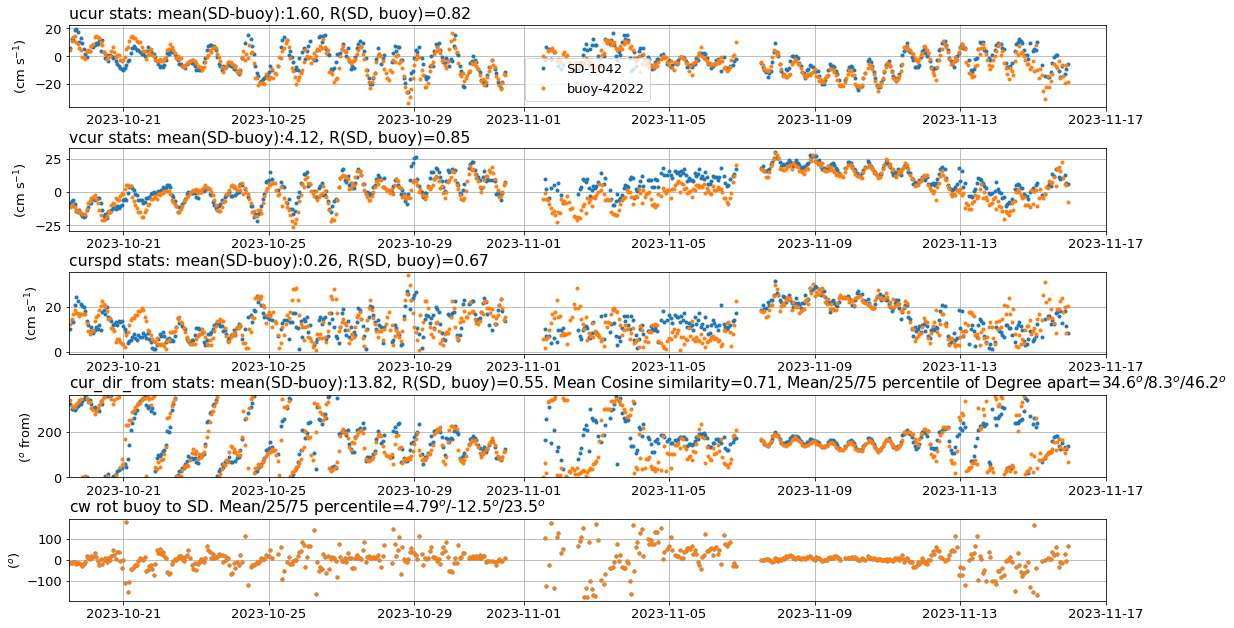

In [68]:
### compute current speed
curspd_SD_common = np.sqrt( np.square(ucur_SD_common) + np.square(vcur_SD_common) )
curspd_buoy_common = np.sqrt( np.square(ucur_buoy_common) + np.square(vcur_buoy_common) )
isOK_common = ~np.isnan(ucur_SD_common) & ~np.isnan(ucur_buoy_common)
print(np.sum(isOK_common),)
### compute cosine similarity
vector_SD = np.column_stack( (ucur_SD_common,vcur_SD_common) )
vector_buoy = np.column_stack( (ucur_buoy_common,vcur_buoy_common) )
cosine_SD_buoy = np.sum(vector_SD*vector_buoy, axis=1)/(norm(vector_SD,axis=1)*norm(vector_buoy,axis=1))
deg_apart_btw_SD_buoy = np.nan*np.ones(cosine_SD_buoy.shape)
for i in range( len(cosine_SD_buoy) ):
    deg_apart_btw_SD_buoy[i] = math.degrees( math.acos(cosine_SD_buoy[i]) ) # convert radians to degree
perc = [25,75]
deg_apart_perc = np.percentile(deg_apart_btw_SD_buoy[isOK_common],perc)
### compute degree from buoy dir to SD dir (positive clockwise)
deg_cur_buoy2SD_clockwise = (cur_dir_from_SD_common-cur_dir_from_buoy_common)
deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise> 180] = deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise> 180]-360
deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise< -180] = deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise< -180]+360
deg_cur_buoy2SD_perc = np.percentile(deg_cur_buoy2SD_clockwise[isOK_common],perc)
###
var_str = ['ucur','vcur','curspd','cur_dir_from','cw rot buoy to SD']
var_unit = ['(cm s$^{-1}$)','(cm s$^{-1}$)','(cm s$^{-1}$)','($^o$ from)','($^o$)']
nrow = len(var_str)
plt.clf()
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
for i in range( len(var_str) ):
    plt.subplot(nrow,1,i+1)
    if i < len(var_str)-1:
        exec_str1 = 'var1 = '+var_str[i]+'_SD_common'
        exec_str2 = 'var2 = '+var_str[i]+'_buoy_common'
    else:
        exec_str1 = 'var1 = deg_cur_buoy2SD_clockwise'
        exec_str2 = 'var2 = deg_cur_buoy2SD_clockwise'
    exec(exec_str1)
    exec(exec_str2)
    plt.plot( dtime_cur_common, var1,'.',label='SD-'+platf_num )
    plt.plot( dtime_cur_common, var2,'.',label='buoy-'+buoy_id )
    if i < len(var_str)-1:
        r = np.corrcoef(var1[isOK_common], var2[isOK_common])
        mn = np.mean(var1[isOK_common]-var2[isOK_common])
    # print(var_str[i]+' diff (SD({:.1f}m)-buoy({:.1f}m)):{:.2f}'.format(depths_cur_SD[iz_SD],depths_cur_buoy[iz_buoy],mn), 'R={:.2f}'.format(r[0][1]))
    ### print stats on title
    if i < 3:
        plt.title(var_str[i]+' stats: mean(SD-buoy):{:.2f}, R(SD, buoy)={:.2f}'.format(mn,r[0][1]),loc='left')
    elif i == 3:
        plt.title(var_str[i]+' stats: mean(SD-buoy):{:.2f}, R(SD, buoy)={:.2f}. Mean Cosine similarity={:.2f}, Mean/{:.0f}/{:.0f} percentile of Degree apart={:.1f}$^o$/{:.1f}$^o$/{:.1f}$^o$'.\
                  format(mn,r[0][1],np.nanmean(cosine_SD_buoy),perc[0],perc[1],np.nanmean(deg_apart_btw_SD_buoy),deg_apart_perc[0],deg_apart_perc[1]),loc='left')
    else:
        plt.title(var_str[i]+'. Mean/{:.0f}/{:.0f} percentile={:.2f}$^o$/{:.1f}$^o$/{:.1f}$^o$'.\
                  format(perc[0],perc[1],np.nanmean(deg_cur_buoy2SD_clockwise),deg_cur_buoy2SD_perc[0],deg_cur_buoy2SD_perc[1]),loc='left')
    
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
    plt.xlim(tlim_plot)
    plt.ylabel(var_unit[i])
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylim([0,360])

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.5)
### save to figure
plt.savefig('timeseries_cur_dir_SD'+platf_num+'({:.1f}m-QC)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

deg_buoy2SD_clockwise limits: -75.19~117.61
deg_cur_buoy2SD_clockwise limits: -176.43~177.53


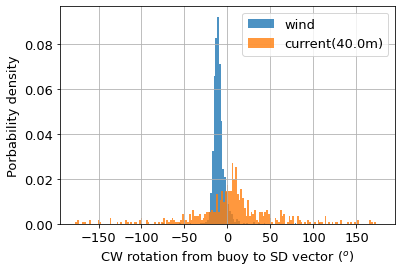

In [69]:
varnms = ['deg_buoy2SD_clockwise','deg_cur_buoy2SD_clockwise']
str_leg = ['wind','current({:.1f}m)'.format(depths_cur_SD[iz_SD])]
for v, varnm in enumerate( varnms ):
    var_plot = eval(varnm)
    varlim = [np.nanmin(var_plot), np.nanmax(var_plot)]
    print(varnm+' limits: {:.2f}~{:.2f}'.format(varlim[0], varlim[1]))
    plt.hist(var_plot, bins=np.arange(np.floor(varlim[0]),np.ceil(varlim[1]),2), density='True', alpha=0.8, label=str_leg[v])
plt.legend(loc='best')
plt.grid()
plt.ylabel('Porbability density')
plt.xlabel('CW rotation from buoy to SD vector ($^o$)')
### save figure
plt.savefig('pdf_CW-rot_wind_cur_dir_from-buoy'+buoy_id+'({:.1f}m)-to-SD'.format(depths_cur_buoy[iz_buoy])+platf_num+'({:.1f}m-QC)'.format(depths_cur_SD[iz_SD])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')